In [1]:
import numpy as np
import cv2 
import matplotlib.pyplot as plt
import pandas as pd
from PIL import Image
import glob
import os
from os import *
import re
import imutils
from skimage.feature import peak_local_max
from skimage.morphology import watershed
from scipy import ndimage
import collections
import random

In [2]:
def atoi(text):
    return int(text) if text.isdigit() else text
def natural_keys(text):
    return [atoi(c) for c in re.split('(\d+)', text)]


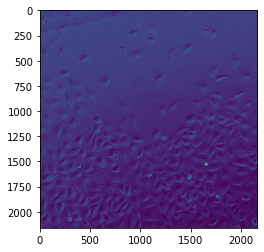

In [3]:
img = cv2.imread('/home/jovyan/A549-TL-pilot_C03_s15DA8D61F-A330-4B36-B171-1DB8D1E88898.tif', 0)
plt.imshow(img)

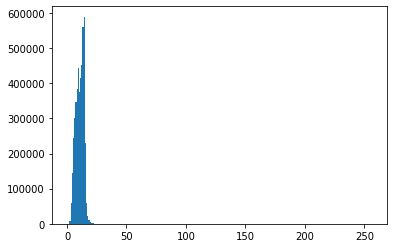

In [4]:
plt.hist(img.ravel(),256,[0,256]) 
plt.show() 

In [5]:
dft = cv2.dft(np.float32(img), flags=cv2.DFT_COMPLEX_OUTPUT)
dft_shift = np.fft.fftshift(dft)
magnitude_spectrum = 20 * np.log(cv2.magnitude(dft_shift[:, :, 0], dft_shift[:, :, 1]))

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:21: RuntimeWarning: divide by zero encountered in log


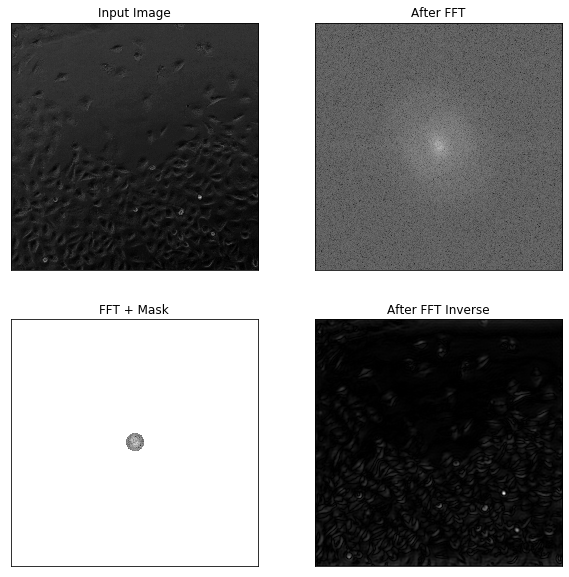

In [6]:
rows, cols = img.shape
crow, ccol = int(rows / 2), int(cols / 2)  # center

# Concentric BPF mask,with are between the two cerciles as one's, rest all zero's.
rows, cols = img.shape
crow, ccol = int(rows / 2), int(cols / 2)

mask = np.zeros((rows, cols, 2), np.uint8)
r_out = 80
r_in = 5
center = [crow, ccol]
x, y = np.ogrid[:rows, :cols]

mask_area = np.logical_and(((x - center[0]) ** 2 + (y - center[1]) ** 2 >= r_in ** 2),
                           ((x - center[0]) ** 2 + (y - center[1]) ** 2 <= r_out ** 2))
mask[mask_area] = 1

# apply mask and inverse DFT
fshift = dft_shift * mask

fshift_mask_mag = 2000 * np.log(cv2.magnitude(fshift[:, :, 0], fshift[:, :, 1]))

f_ishift = np.fft.ifftshift(fshift)
img_back = cv2.idft(f_ishift)
img_back = cv2.magnitude(img_back[:, :, 0], img_back[:, :, 1])

fig = plt.figure(figsize=(10, 10))

ax= fig.add_subplot(2, 2, 1), plt.imshow(img, cmap='gray')
plt.title('Input Image'), plt.xticks([]), plt.yticks([])
plt.subplot(2, 2, 2), plt.imshow(magnitude_spectrum, cmap='gray')
plt.title('After FFT'), plt.xticks([]), plt.yticks([])
plt.subplot(2, 2, 3), plt.imshow(fshift_mask_mag, cmap='gray')
plt.title('FFT + Mask'), plt.xticks([]), plt.yticks([])
plt.subplot(2, 2, 4), plt.imshow(img_back, cmap='gray')
plt.title('After FFT Inverse'), plt.xticks([]), plt.yticks([])
plt.show()

In [7]:
filtered_img = np.abs(img_back)
filtered_img -= filtered_img.min()
filtered_img = filtered_img*255 / filtered_img.max()
filtered_img = filtered_img.astype(np.uint8)

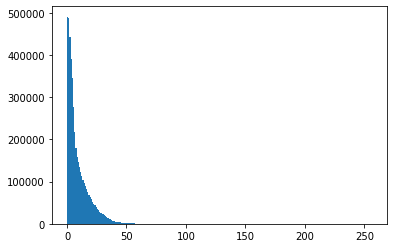

In [8]:
plt.hist(filtered_img.ravel(),256,[0,256]) 
plt.show() 

In [9]:
i = cv2.cvtColor(filtered_img,cv2.COLOR_GRAY2BGR)

In [10]:
Z = i.reshape((-1,3))


In [11]:
Z = np.float32(Z)

In [12]:
criteria = (cv2.TERM_CRITERIA_EPS + cv2.TERM_CRITERIA_MAX_ITER, 10, 1.0)
K = 2
ret,label,center=cv2.kmeans(Z,K,None,criteria,10,cv2.KMEANS_RANDOM_CENTERS)

In [13]:
center = np.uint8(center)
res = center[label.flatten()]
res2 = res.reshape((i.shape))

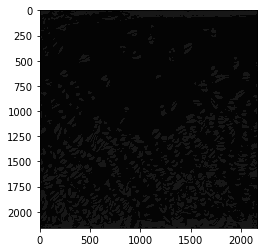

In [14]:
plt.imshow(res2)

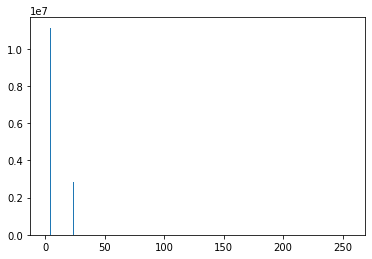

In [15]:
plt.hist(res2.ravel(),256,[0,256]) 
plt.show() 

In [16]:
res2.shape

(2160, 2160, 3)

In [ ]:
shifted = cv2.pyrMeanShiftFiltering(res2, 10, 50)
plt.imshow(shifted)

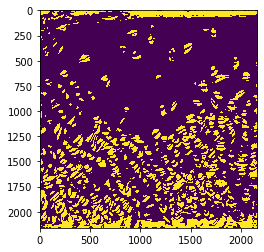

In [17]:
gray = cv2.cvtColor(res2,cv2.COLOR_BGR2GRAY)
thresh = cv2.threshold(gray, 0, 255, cv2.THRESH_BINARY | cv2.THRESH_OTSU)[1]
plt.imshow(thresh)

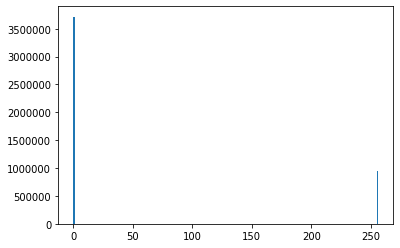

In [18]:
plt.hist(thresh.ravel(),256,[0,256]) 
plt.show() 

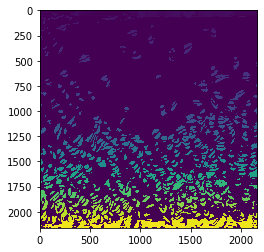

In [19]:
D = ndimage.distance_transform_edt(thresh)
localMax = peak_local_max(D, indices=False, min_distance=9, labels=thresh)

markers = ndimage.label(localMax, structure=np.ones((3, 3)))[0]
labels = watershed(-D, markers, mask=thresh)
plt.imshow(labels)

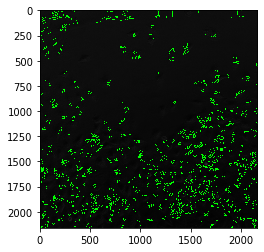

In [20]:
ar = []
cx = []
cy = []
img2 = cv2.cvtColor(img, cv2.COLOR_GRAY2RGB)
for label in np.unique(labels):
    if label == 0:
        continue
        
    
    mask = np.zeros(gray.shape, dtype='uint8')
    mask[labels == label] = 255
    cnts = cv2.findContours(mask.copy(), cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_NONE)
    
    
    
    cnts = imutils.grab_contours(cnts)
    c = max(cnts, key=cv2.contourArea)
    ((x, y), r) = cv2.minEnclosingCircle(c)
    area = cv2.contourArea(c)
    if area < 900:
        cx.append(int(x))
        cy.append(int(y))
        ar.append(area)

        cv2.drawContours(img2, [c], -1,(0, 255, 0), 2)
        #cv2.circle(img2, (int(x), int(y)), 3, (0, 255, 0), -1)

plt.imshow(img2)

In [ ]:
cx

In [21]:
#cv2.imwrite('/home/jovyan/tr.png', img2)

True